In [46]:
import numpy as np
import pandas as pd
import os
import glob

In [47]:
DATA_PATH    = 'downloader-data'
TICKERS_PATH = 'tickers'

## 1 - data collection

### read tickers

In [48]:
ticker_files = glob.glob(f'{TICKERS_PATH}/*')
ticker_dfs = []
for tf in ticker_files[1:]:
    ticker_dfs.append(pd.read_csv(tf))

tickers = pd.concat(ticker_dfs, ignore_index=True)


### read data

In [49]:
data_for_ticker = {}
for index, (ticker, name) in tickers.iterrows():
    try:
        df = pd.read_csv(f'{DATA_PATH}/{ticker}.csv')
        if len(df) > 100:
            data_for_ticker[ticker] = df
    except:
        pass
    
print(data_for_ticker['AAPL'])

           Date       Close     Volume
0    2020-10-27  116.599998   92276800
1    2020-10-28  111.199997  143937800
2    2020-10-29  115.320000  146129200
3    2020-10-30  108.860001  190272600
4    2020-11-02  108.769997  122866900
..          ...         ...        ...
248  2021-10-21  149.479996   61421000
249  2021-10-22  148.690002   58839600
250  2021-10-25  148.639999   50720600
251  2021-10-26  149.320007   60893400
252  2021-10-27  148.850006   55951800

[253 rows x 3 columns]


## 2 - assets map

### compute log return

In [50]:
for ticker, data in data_for_ticker.items():
    data_for_ticker[ticker] = data.assign(logret=np.log(data.Close).diff())
    data_for_ticker[ticker]['minus_logret'] = data_for_ticker[ticker]['logret'].mul(-1)

In [51]:
data_for_ticker['AAPL']

,Date,Close,Volume,logret,minus_logret
0,2020-10-27,116.599998,92276800,NaN,NaN
1,2020-10-28,111.199997,143937800,-0.047419,0.047419
2,2020-10-29,115.320000,146129200,0.036381,-0.036381
3,2020-10-30,108.860001,190272600,-0.057648,0.057648
4,2020-11-02,108.769997,122866900,-0.000827,0.000827
...,...,...,...,...,...
248,2021-10-21,149.479996,61421000,0.001473,-0.001473
249,2021-10-22,148.690002,58839600,-0.005299,0.005299
250,2021-10-25,148.639999,50720600,-0.000336,0.000336
251,2021-10-26,149.320007,60893400,0.004564,-0.004564


### compute logret_mean, logret_std

In [52]:
estims = pd.DataFrame(data=[], columns=['ticker', 'logret_mean', 'logret_std'])
estims.set_index('ticker', inplace=True)

for ticker, data in data_for_ticker.items():
    estims.loc[ticker] = [data['logret'].mean(), data['logret'].std()]
    
estims

,logret_mean,logret_std
ticker,,
AAIT,0.002652,0.023450
AAL,0.002093,0.031258
AAME,0.002481,0.070508
AAOI,-0.001026,0.036126
AAON,0.000559,0.016321
...,...,...
UPRO,0.003376,0.024899
LIFE,0.003917,0.064695
FLOT,0.000009,0.000302


### plot the map

In [53]:
import plotly.express as px
from sklearn.preprocessing import normalize

ticker_colour = estims['logret_mean'] / estims['logret_std']
ticker_size = (ticker_colour - ticker_colour.min()) / ticker_colour.max()
fig = px.scatter(estims, x='logret_std', y='logret_mean',
                 hover_name=estims.index, 
                 color_continuous_scale=px.colors.diverging.RdYlGn,
                 color=ticker_colour)
fig.show()

## 3 - uniform portfolio

In [54]:
import plotly.graph_objects as go

# TODO: check
uniform_logret_mean = estims['logret_mean'].mean()
uniform_logret_std = estims['logret_std'].mean()

print(f'UNIFORM std:{uniform_logret_std}, mean:{uniform_logret_mean}')

fig.add_scatter(x=[uniform_logret_std], y=[uniform_logret_mean], text=['Uniform Portfolio'], mode="markers",
                marker=dict(size=20, color="Blue"), name='UNIFORM', secondary_y=False,)

fig.update_layout(
    legend = dict(
        x=0.89,
        y=1,
        traceorder="normal",
        font = dict(family = "Courier", size = 10)
    )
)
fig.show()

UNIFORM std:0.035793795775315836, mean:0.0007932805203758977


## 5 - VaR

In [55]:
def getVaR(data, tLVL):
    if isinstance(data, pd.DataFrame):
        return data.aggregate(getVaR, tLVL=tLVL)
    elif isinstance(data, pd.Series):
        return -np.percentile(data, tLVL)
    else:
        raise TypeError("Expected data to be a Series or DataFrame")

In [56]:
TRUST_LEVELS = [90, 95, 97.5]

tickersVaRs = pd.DataFrame(data=[], columns=['ticker'] + [f'VaR-{tLVL}' for tLVL in TRUST_LEVELS])

# compute VaR to tickers     
for index, (ticker, data) in enumerate(data_for_ticker.items()):
    tickersVaRs_row = [ticker]
    for tLVL in TRUST_LEVELS:
        quantile_value = getVaR(data['minus_logret'][1:], tLVL)
        tickersVaRs_row.append(quantile_value)
    tickersVaRs.loc[index] = tickersVaRs_row
            
# plot values     
tickersVaRs

,ticker,VaR-90,VaR-95,VaR-97.5
0,AAIT,-0.018250,-0.026633,-0.031713
1,AAL,-0.034068,-0.042276,-0.051093
2,AAME,-0.050082,-0.080964,-0.120486
3,AAOI,-0.038192,-0.048129,-0.063951
4,AAON,-0.017699,-0.027576,-0.032332
...,...,...,...,...
1948,UPRO,-0.024111,-0.039162,-0.049450
1949,LIFE,-0.052852,-0.073396,-0.090267
1950,FLOT,-0.000394,-0.000394,-0.000591
1951,AQUA,-0.025068,-0.033303,-0.043262


In [57]:
import plotly.express as px

for tLVL in TRUST_LEVELS:
    VaR_column = f'VaR-{tLVL}'
    tickersVaRs = tickersVaRs.sort_values(by=VaR_column, ascending=False)
    
    tLVL_fig = px.bar(tickersVaRs, x='ticker', y=VaR_column,
                 color=f'{VaR_column}', color_continuous_scale=px.colors.diverging.RdYlGn,
                 height=400)
    tLVL_fig.show()

In [58]:
tickersVaRs = tickersVaRs.sort_values(by='VaR-95', ascending=False)
best_VaR_ticker = tickersVaRs['ticker'].iloc[0]
best_VaR_mean = estims.loc[best_VaR_ticker]['logret_mean']
best_VaR_std = estims.loc[best_VaR_ticker]['logret_std']

print(f'Best Var Ticker - {best_VaR_ticker}, std:{best_VaR_std}, mean:{best_VaR_mean}')

fig.add_scatter(x=[best_VaR_std], y=[best_VaR_mean], mode="markers",
                marker=dict(size=20, color="Brown"), text=['Best VaR'], name='Best VaR')

fig.update_layout(
    legend = dict(
        x=0.89,
        y=1,
        traceorder="normal",
        font = dict(family = "Courier", size = 10)
    )
)


Best Var Ticker - FTSM, std:0.00016256045116684885, mean:-1.1906775149388039e-05


## 6 - White Noise Check

### select tickers

In [59]:
tickers = tickersVaRs['ticker'].iloc[:4].values
for ticker in tickers:
    print(ticker)

FTSM
FLOT
VGSH
ULTR


### logret data

In [60]:
joint_data = pd.DataFrame(data=[], columns=[])
joint_data['Date'] = data_for_ticker[tickers[0]]['Date'][1:]

for ticker in tickers:
    data = data_for_ticker[ticker]
    joint_data[ticker] = data['logret'][1:]
    
print(joint_data)

           Date      FTSM      FLOT      VGSH      ULTR
1    2020-10-28 -0.000166  0.000000  0.000000 -0.001007
2    2020-10-29 -0.000166  0.000000  0.000000  0.000403
3    2020-10-30 -0.000333  0.000000  0.000000  0.000604
4    2020-11-02 -0.000167 -0.000592 -0.000806 -0.001713
5    2020-11-03 -0.000167  0.000197 -0.000161  0.000504
..          ...       ...       ...       ...       ...
248  2021-10-21 -0.000250 -0.000394 -0.001143 -0.000607
249  2021-10-22  0.000167  0.000000 -0.000490 -0.000202
250  2021-10-25 -0.000167 -0.000394  0.000490  0.000405
251  2021-10-26  0.000000  0.000394 -0.000163  0.000101
252  2021-10-27  0.000000  0.000197  0.000163 -0.000506

[252 rows x 5 columns]


In [61]:
print(joint_data.describe())

             FTSM        FLOT        VGSH        ULTR
count  252.000000  252.000000  252.000000  252.000000
mean    -0.000012    0.000009   -0.000053   -0.000022
std      0.000163    0.000302    0.000541    0.000867
min     -0.000500   -0.001181   -0.006470   -0.006439
25%     -0.000167   -0.000197   -0.000163   -0.000302
50%      0.000000    0.000000    0.000000    0.000000
75%      0.000083    0.000197    0.000163    0.000303
max      0.000501    0.000986    0.001786    0.006439


### logrets hist plots

In [62]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=2, cols=2, subplot_titles=tickers)
plots = sorted([[row, col] for col in range(1, 3) for row in range(1, 3)])

for ticker, (row, col) in zip(tickers, plots):
    fig.add_trace(
        go.Histogram(name=ticker, x=joint_data[ticker]),
        row=row, 
        col=col
    )
    
fig.show()

### autocorrelation plots

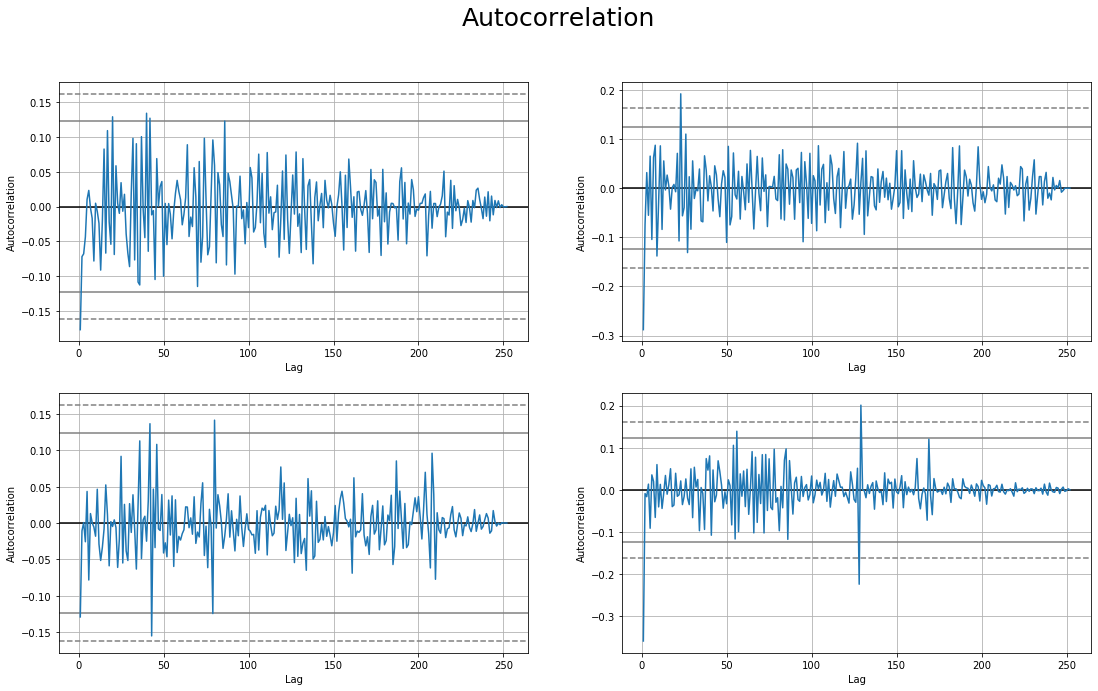

In [63]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
fig.suptitle('Autocorrelation', fontsize=25)
fig.set_size_inches(18.5, 10.5)
plots = sorted([[row, col] for col in range(0, 2) for row in range(0, 2)])

for ticker, (row, col) in zip(tickers, plots):
    autocorrelation_plot(joint_data[ticker], ax=axs[row, col])

### apply ljung-box test

In [64]:
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

pvalues = []

for ticker in tickers:
    # fit ARMA model to data
    res = sm.tsa.ARMA(joint_data[ticker], (1,1)).fit(disp=-1)
    # perform Ljung-Box test on residuals with lag=5
    stat, pvalue = sm.stats.acorr_ljungbox(res.resid, lags=[5])
    pvalues.append(pvalue[0])
    

In [65]:
import plotly.express as px

alpha = 0.05

pvalues_fig = px.bar(x=['alpha', *tickers], 
                     y=[alpha, *pvalues],
                     color=[alpha, *pvalues],
                     color_continuous_scale=px.colors.diverging.RdYlGn[::-1],
                     height=400, title='Ljung-Box test p-values')

pvalues_fig.show()